In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path = "C:/Users/Camer/OneDrive/desktop/College/Digital Tools/DigitalTools_project/research_project/src/data/"

In [5]:
BTC = pd.read_csv(path + "BTC-USD.csv")
BTC['Date'] = pd.to_datetime(BTC['Date'], format='%Y/%m/%d')
BTC = BTC.set_index('Date',drop=True)

Get daily range for data

In [11]:
BTC['Range'] = BTC.High - BTC.Low

Functions to get all the data before and after a particular date.
Ensure the data is in correct format - date and index.

In [49]:
def before(data,date,period):
    ind = data.index.get_loc(date)
    
    start = max(0,ind-period)
    
    return(data.iloc[start:ind])

def after(data,date,period):
    ind = data.index.get_loc(date)
    
    end = min(len(BTC),ind+period+1)
    
    return(data.iloc[ind+1:end])

Moving Average

In [74]:
def MA(data,colname,period):
    data['MA_'+str(period)] = 0
    for ind in range(period-1,len(data)):
        start = ind - period + 1
        end = ind
        
        data['MA_'+str(period)].iloc[ind] = np.mean(data[colname].iloc[start:end])
    return

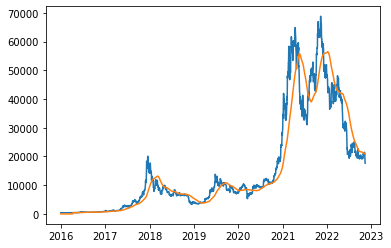

In [83]:
MA(BTC,'High',100)

plt.plot(BTC.High)
plt.plot(BTC.MA_100)